# Lab 8
Author: Yunting Chiu

Mail: yc6705a@american.edu

In [5]:
# install the library
library(tidyverse)

## Stuntized Residuals and Outliers


The following objects are masked from mtcars (pos = 3):

    am, carb, cyl, disp, drat, gear, hp, mpg, qsec, vs, wt


The following objects are masked from mtcars (pos = 4):

    am, carb, cyl, disp, drat, gear, hp, mpg, qsec, vs, wt


The following object is masked from package:ggplot2:

    mpg




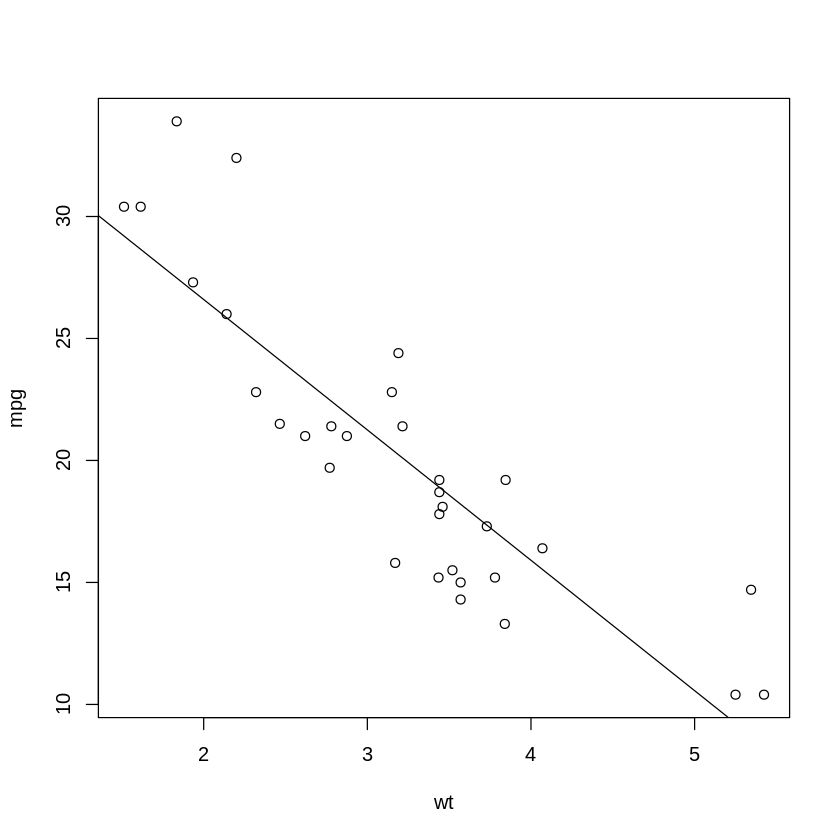

In [6]:
attach(mtcars)
reg = lm( mpg ~ wt )
plot(wt, mpg)
abline(reg)

We will focus on **residual plots**.
- Residuals vs Fitted: see the yhat vs ei.
- Normal QQ: drawing up the data to check whether or not they follow a normal distribution.
- Scale-Location: testing the variance is constant or not. The ideal case is the data points along with the horizontal line.
- Residual vs Leverage: finding the influantial observations on this plot. The data point is above the dust line, which means that it would probably be an influential point.







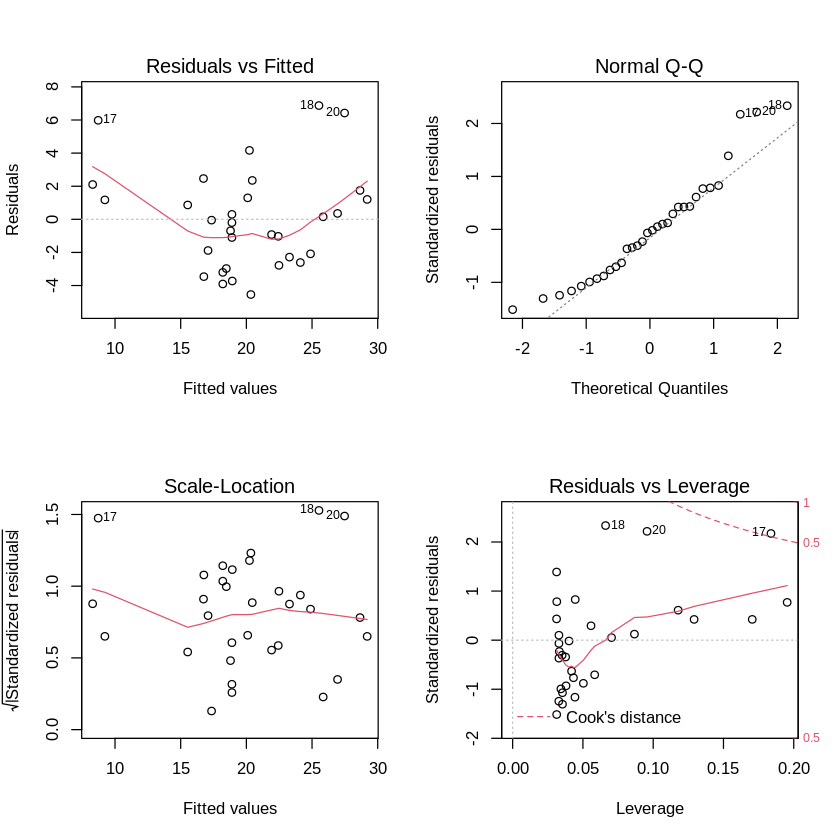

In [9]:
par(mfrow = c(2, 2)) # Return to the 2x2 plot window
plot(reg)

## Studentized residuals and testing for outliers

1           2           3           4           5           6 
-0.76076977 -0.30274050 -0.69972329  0.42681176 -0.06570059 -0.22779587 
          7           8           9          10          11          12 
-1.32167204  1.41169344  0.77876838  0.09844187 -0.36192838  0.28837628 
         13          14          15          16          17          18 
-0.01655496 -0.62515414  0.41709709  0.76444774  2.32816206  2.53780106 
         19          20          21          22          23          24 
 0.60385911  2.38384376 -0.87622897 -0.99290217 -1.25610443 -1.16991451 
         25          26          27          28          29          30 
 0.82326228  0.12041613  0.05090396  0.41668241 -1.55056010 -0.92873434 
         31          32 
-1.07426703 -0.33877056

17       18       20 
2.328162 2.537801 2.383844

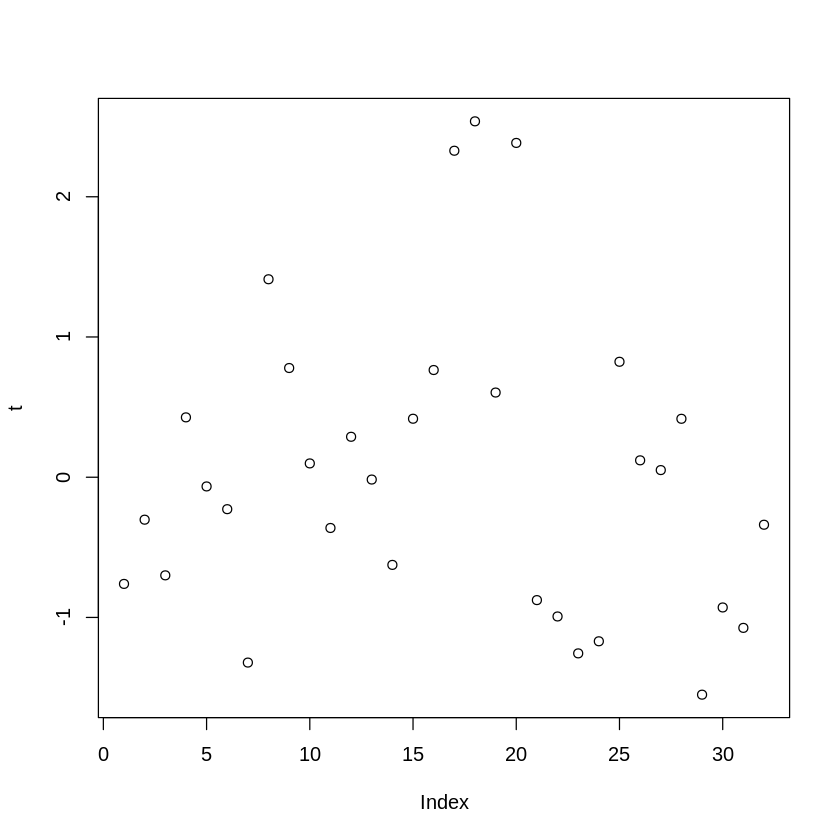

In [12]:
t = rstudent(reg) # Studentized residuals
t
par(mfrow=c(1,1)) # Return to the 1x1 plot window
plot(t) # See if there are any nonlinear trends
t[abs(t)>2]